# From Scratch: Training a Neural Network to Classify Spiral Datasets 2

## What's new?

1. SGD: NN is trained on mini-batches rather than on the entire dataset.
2. Split dataset into training/validation/test set:
    - 3/5, 1/5, 1/5: train/val/test split
    - validate the learning rate and the regularization strength
    - evaluate the validation/test accuracy
    
The result shows that the effect of learning rate is far superior to the one from the regularization strength.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('classic')
plt.style.use('seaborn')

## Generate and Split Data into Training/Validation/Test Data

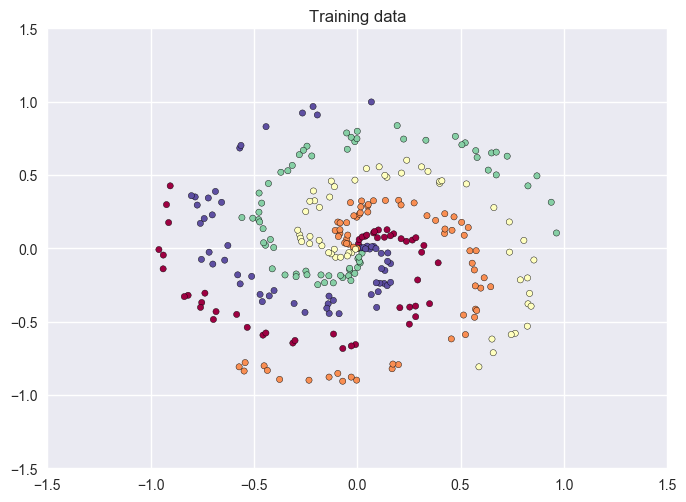

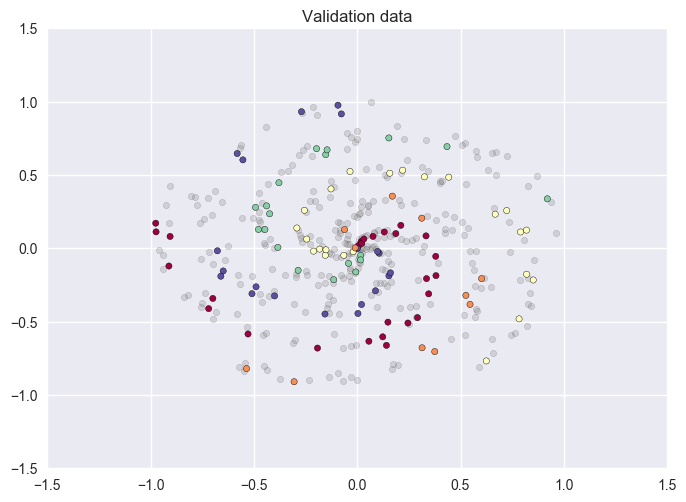

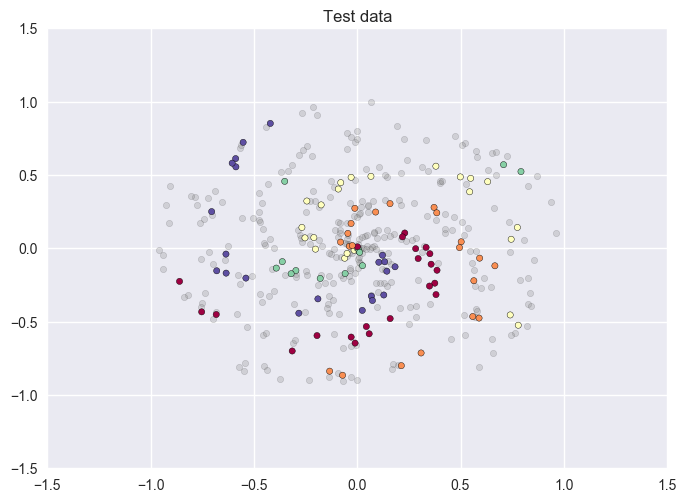

In [2]:
N = 100  # num of points per class
D = 2  # data dimension
K = 5  # num of classes, i.e. spirals


# Create "containers" to store ALL data, split later
X = np.zeros((N* K,D)) 
Y = np.zeros((N* K, 1))

# Each row -> a training example
# 3/5: training, 1/5: validation, test data
test_size = val_size = int(N* K/ 5)

trainX = np.zeros((N*K - test_size,D)) 
trainY = np.zeros((N*K - test_size, 1))

valX = np.zeros((test_size, D))
valY = np.zeros((test_size, 1))

testX = np.zeros((test_size, D))
testY = np.zeros((test_size, 1))


c = 2* math.pi* (K-1) / K
for j in range(K):
    ix = range(N* j, N* (j+1))
    
    # Radius
    r = np.linspace(0., 1, N)

    # Angle
    t = np.linspace(j* c, (j + 1)* c, N) + np.random.randn(N)* .2
    
    X[ix] = np.c_[r* np.sin(t), r* np.cos(t)]
    Y[ix] = j
    
    
# Shuffle the data for SGD and split training/test set
Z = np.hstack((X, Y))
np.random.shuffle(Z)

# Training set
trainX = Z[:-test_size*2, :2]
trainY = Z[:-test_size*2, 2].astype('uint8')
    
# Test set
# Note: we shuffle the data randomly, so the test set is random (may not be uniform)
valX = Z[-test_size*2:-test_size, :2]
valY = Z[-test_size*2:-test_size, 2].astype('uint8')
testX = Z[-test_size:, :2]
testY = Z[-test_size:, 2].astype('uint8')
    
# Plot training set
plt.title('Training data')
plt.scatter(trainX[:, 0], trainX[:, 1], c=trainY, cmap=plt.cm.Spectral)
plt.show()

# Plot validation set
# Gray dots denote the training data
plt.title('Validation data')
plt.scatter(trainX[:, 0], trainX[:, 1], c='gray', cmap=plt.cm.Spectral, alpha=0.25)
plt.scatter(valX[:, 0], valX[:, 1], c=valY, cmap=plt.cm.Spectral)
plt.show()

# Plot test set
# Gray dots denote the training data
plt.title('Test data')
plt.scatter(trainX[:, 0], trainX[:, 1], c='gray', cmap=plt.cm.Spectral, alpha=0.25)
plt.scatter(testX[:, 0], testX[:, 1], c=testY, cmap=plt.cm.Spectral)
plt.show()

## Define Model

In [3]:
H = 100  # num of hidden units

# Model
W1 = np.random.randn(D,H)* 1e-2
b1 = np.zeros((1,H))
W2 = np.random.randn(H,K)* 1e-2
b2 = np.zeros((1,K))

## Training

### Training iteration

In [4]:
def train_step(X, Y, W1, b1, W2, b2, lr, reg, epochs=10000, plot_loss=True):
    loss_lst = []
    
    N = trainX.shape[0]
    batch_size = int(N / 5)  # 1/5 dataset as mini-batch size

    
    # Gradient descent loop
    for i in range(epochs+1):
    
        """
        Sample a mini-batch
        """
        mini_batch = np.random.randint(N, size=batch_size)
        X = trainX[mini_batch]
        y = trainY[mini_batch]

        """
        Forward-propagation
        """
        # Hidden layer
        Y1 = X.dot(W1) + b1
        H1 = np.maximum(Y1, 0)  # relu activation

        # Output layer
        Y2 = H1.dot(W2) + b2

        # Subtract max. output for numerical stability
        Y2 -= np.amax(Y2, axis=1, keepdims=True)

        # Softmax
        exp_Y2 = np.exp(Y2)
        softmax = exp_Y2 / exp_Y2.sum(axis=1, keepdims=True)

        # Compute loss: average cross-entropy loss and regularization loss
        Loss_i = -np.log(softmax[range(batch_size),y])  # CE loss for each training example

        data_loss = Loss_i.mean()
        reg_loss = 0.5* reg* (np.sum(W1**2)+ np.sum(W2**2))
        Loss = data_loss + reg_loss

        loss_lst.append(Loss)

        if i % 2000 == 0: print('Epoch {0}: loss {1}'.format(i, Loss.round(4)))

            
        """
        Back-propagation
        Order: dY2 -> dW2, db2, dH1 -> dY1 -> dW1, db1
        """
        # dY2
        dY2 = softmax
        dY2[range(batch_size),y] -= 1
        dY2 /= N

        # dW2 & db2
        dW2 = H1.T.dot(dY2)
        db2 = dY2.sum(axis=0, keepdims=True)

        # dH1
        dH1 = dY2.dot(W2.T)

        # dY1
        dY1 = dH1* (Y1 > 0)

        # dW1 & db1
        dW1 = X.T.dot(dY1)
        db1 = dY1.sum(axis=0, keepdims=True)

        # Add up regularization losses
        dW2 += reg* W2
        dW1 += reg* W1


        """
        Parameter update
        """
        W1 -= lr* dW1
        b1 -= lr* db1
        W2 -= lr* dW2
        b2 -= lr* db2
    
    if plot_loss:
        plt.plot(loss_lst)
        plt.show()
        
    return W1, b1, W2, b2, loss_lst

## Evaluate Training Accuracy and Plot Decision Boundary

In [5]:
def evaluate_and_plot(X, Y, W1, b1, W2, b2, evaluate=True, plot=True):
    if evaluate:
        # Compute output
        Y1 = X.dot(W1) + b1
        H1 = np.maximum(Y1, 0)
        Y2 = H1.dot(W2) + b2

        # Compute training accuracy
        pred = Y2.argmax(axis=1)
        accu = float(np.mean(pred == Y))  # convert np.float64 to original float
        print('Accuracy: {0:.2f}'.format(accu))
        
    if plot:
        # Plot the resulting classifier with training data
        h = 0.01

        # Pick boundaries of x and y
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Forward pass to compute output
        Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
        plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())

        plt.show()
        
    return accu

In [6]:
# Combinations of hyper-params
lr_lst = [1e0, 1e-1, 1e-2]
lr = np.array(lr_lst)

reg_lst = [1e-3, 1e-4, 1e-5, 1e-6]
reg = np.array(reg_lst)

xx, yy = np.meshgrid(lr, reg)
zz = np.c_[xx.ravel(), yy.ravel()]


loss_lst2 = []  # record loss of each iteration
accu = 0.
hparam = None
for p in zz:
    print('Learning rate: {0:1.1e}\nReg. Strength: {1:1.1e}'.format(*p))
    
    # Training
    _W1, _b1, _W2, _b2, loss_lst = \
        train_step(trainX, trainY, 
                   W1.copy(), b1.copy(), W2.copy(), b2.copy(), 
                   *p, epochs=10000,
                   plot_loss=False)

    _ = evaluate_and_plot(trainX, trainY,
                          _W1, _b1, _W2, _b2,
                          plot=False)
    
    # Validation
    _accu = evaluate_and_plot(valX, valY,
                              _W1, _b1, _W2, _b2,
                              plot=False)
    print()
    
    # Record the best parameter
    if _accu > accu:
        W1_final = _W1
        b1_final = _b1
        W2_final = _W2
        b2_final = _b2
        
        hparam = p
        
        accu = _accu
    
    loss_lst2.append(loss_lst)

Learning rate: 1.0e+00
Reg. Strength: 1.0e-03
Epoch 0: loss 1.6094
Epoch 2000: loss 1.4051
Epoch 4000: loss 1.041
Epoch 6000: loss 0.97
Epoch 8000: loss 1.0182
Epoch 10000: loss 0.9558
Accuracy: 0.66
Accuracy: 0.57

Learning rate: 1.0e-01
Reg. Strength: 1.0e-03
Epoch 0: loss 1.6094
Epoch 2000: loss 1.5934
Epoch 4000: loss 1.486
Epoch 6000: loss 1.444
Epoch 8000: loss 1.4259
Epoch 10000: loss 1.3286
Accuracy: 0.29
Accuracy: 0.25

Learning rate: 1.0e-02
Reg. Strength: 1.0e-03
Epoch 0: loss 1.6093
Epoch 2000: loss 1.6027
Epoch 4000: loss 1.5902
Epoch 6000: loss 1.613
Epoch 8000: loss 1.5935
Epoch 10000: loss 1.6069
Accuracy: 0.27
Accuracy: 0.20

Learning rate: 1.0e+00
Reg. Strength: 1.0e-04
Epoch 0: loss 1.6094
Epoch 2000: loss 1.0208
Epoch 4000: loss 0.5654
Epoch 6000: loss 0.5503
Epoch 8000: loss 0.3673
Epoch 10000: loss 0.2882
Accuracy: 0.94
Accuracy: 0.87

Learning rate: 1.0e-01
Reg. Strength: 1.0e-04
Epoch 0: loss 1.6093
Epoch 2000: loss 1.5602
Epoch 4000: loss 1.387
Epoch 6000: loss

Best hyper-param in terms of validation accuracy: 0.93       
Learning rate: 1.0e+00
Reg. Strength: 1.0e-06 


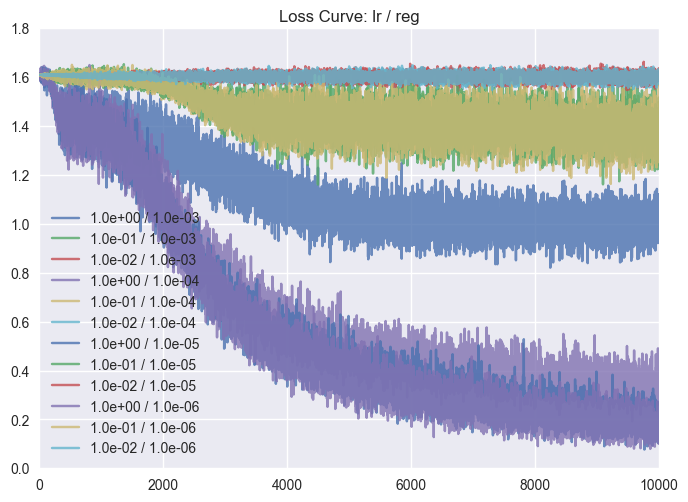

In [7]:
print('Best hyper-param in terms of validation accuracy: {2} \
      \nLearning rate: {0:1.1e}\nReg. Strength: {1:1.1e} '.format(*hparam, accu))

for lst, z in zip(loss_lst2, list(zz)):
    plt.plot(lst, alpha=0.8, label='{0:1.1e} / {1:1.1e}'.format(*z))
plt.title('Loss Curve: lr / reg')
plt.legend(loc='lower left')
plt.show()

## Evaluate Test Accuracy 

Accuracy: 0.89


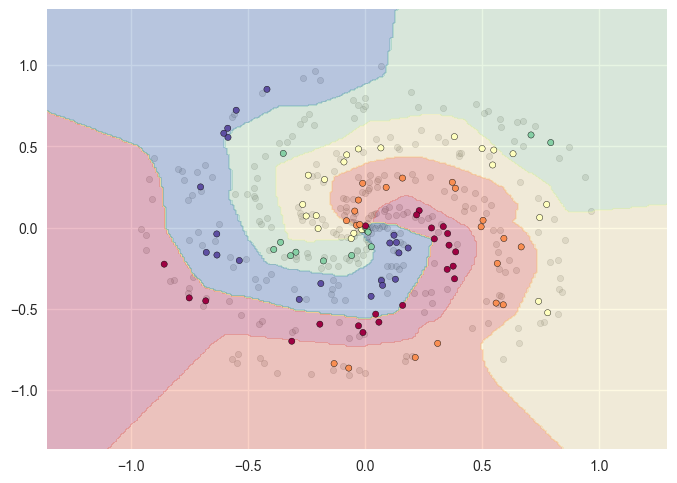

In [8]:
# Evaluate on test set
plt.scatter(trainX[:, 0], trainX[:, 1], c='gray', cmap=plt.cm.Spectral, alpha=0.25)
accu = evaluate_and_plot(testX, testY, W1_final, b1_final, W2_final, b2_final)